# Pollen 

In [1]:
%matplotlib inline
import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# pip install opencv-python
import cv2 as cv

In [2]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset

# 
class PollenDataset(Dataset):
    """class for Pollen dataset."""
    
    # 'pollen_data.csv', base_path
    def __init__(self, csv_file, root_dir, transform=None):
        '''
        '''
        self.root_dir = root_dir
        self.imlist = glob.glob(os.path.join(root_dir, 'images', '*.jpg'))
        self.dataframe = pd.read_csv(csv_file, index_col=0)
        
        self.transform = transform
        self.size =(180,300)
        
    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        '''
        '''
        img_name = os.path.join(self.root_dir,
                                'images',
                                self.dataframe.iloc[idx, 0])
        
        image = cv.imread(img_name)
        image2 = cv.cvtColor(image, cv.COLOR_RGB2BGR)
        image = cv.resize(image2, self.size)

        label = self.dataframe.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        #image = image.transpose(2,0,1)
        
        return (image, label)
    

# Class to display random image and label
def show_random_sample():
    idx = np.random.randint(len(pollen_data))
    image, label = pollen_data[idx]
    label_dict = {0: 'No pollen', 1: 'Pollen'}
    print(label_dict[label])
    plt.imshow(image);
    
def show_random_samples():
    
    label_dict = {0: 'No pollen', 1: 'Pollen'}
    fig = plt.figure(figsize=(12, 5))
    
    for i in range(6):
        plt.subplot(1,6,i+1)
        plt.tight_layout()
        
        idx = np.random.randint(len(pollen_data))
        image, label = pollen_data[idx]
        
        plt.imshow(image, cmap='gray', interpolation='none')
        plt.title(f"{label_dict[label]}")
        plt.xticks([])
        plt.yticks([])
    fig
    

### Instantiate the PollenDataset:

In [3]:
pollen_data = PollenDataset(csv_file='pollen_data.csv',
                            root_dir='/Users/mattjohnson/DeepLearning/A2/PollenDataset')

#### A look at some samples:

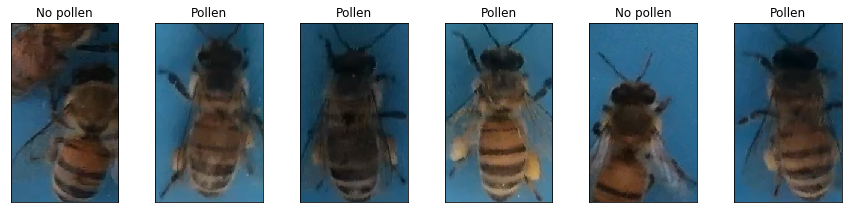

In [4]:
show_random_samples()

### Model Building:

In [5]:
# CNN
#
import torch.nn as nn

class BeeNet(nn.Module):
    def __init__(self):
        super(BeeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.conv3 = nn.Conv2d(32, 2, kernel_size=5)
        self.fc1 = nn.Linear(2*19*34, 50)
        self.fc2 = nn.Linear(50, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        #print('>', x.shape)
        x = x.view(-1,2*19*34)
        #print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        #print(x.shape)
        return F.log_softmax(x)

    def name(self):
        return "BeeNet_f23"

### Model training:

In [6]:
from torch.utils.data.sampler import SubsetRandomSampler

def get_training_and_validation_loaders(dataset):
    batch_size = 16
    validation_split = .2
    shuffle_dataset = True
    random_seed = 8

    # Creating data indices for training and validation splits:
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))

    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(indices)
        
    train_indices, val_indices = indices[split:], indices[:split]

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                               sampler=train_sampler)
    validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                    sampler=valid_sampler)
    
    return train_loader, validation_loader       

In [11]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 
train_loader, validation_loader = get_training_and_validation_loaders(pollen_data)

# HPs
lr = 0.001

# Model
model = BeeNet().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

loss_list = []

#
num_epochs = 2
for epoch in range(num_epochs):
    # Train:   
    for batch_index, (images, labels) in enumerate(train_loader):
        # ...
        images, labels = images.to(device), labels.to(device)
        #images = images
        
        # Forward pass
        outputs = model(images.permute(0, 3, 2, 1).float())
           
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_list.append(loss.item())
        print('loss:', loss.item())
        
    with torch.no_grad():
        
        losses = []
        total = 0
        correct = 0
    
        for images, labels in validation_loader:
            # ...
            images, labels = images.to(device), labels.to(device)
            images.permute(0, 3, 2, 1).float()
            
            # Forward pass
            outputs = model(images.permute(0, 3, 2, 1).float())
            
            loss = criterion(outputs, labels)
        
            # Compute accuracy
            _, argmax = torch.max(outputs, 1)
            correct += (labels == argmax).sum() #.mean()
            total += len(labels)
            
            losses.append(loss.item())
            
        print(f'Step [{epoch+1}/{num_epochs}]')
        try:
            print(f'Loss: {np.mean(losses):.4}, Acc: {correct/total:.2f}')
        except:
            print('correct:', correct)
            print('total:', total)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


loss: 1.0260756015777588
loss: 0.854824423789978
loss: 0.8369307518005371
loss: 0.6228245496749878
loss: 0.7349916100502014
loss: 1.5757644176483154
loss: 0.6522026062011719
loss: 0.6664773225784302
loss: 0.8221111297607422
loss: 0.6902135014533997
loss: 0.7234433889389038
loss: 3.3634397983551025
loss: 0.8080594539642334
loss: 0.6326478719711304
loss: 0.6618145108222961
loss: 0.7041229605674744
loss: 0.6790551543235779
loss: 0.7178148031234741
loss: 0.7192016243934631
loss: 0.6950143575668335
loss: 0.7107258439064026
loss: 0.715718150138855
loss: 0.702256441116333
loss: 0.6933655738830566
loss: 0.7149744033813477
loss: 0.6871204972267151
loss: 0.6815009117126465
loss: 0.686697781085968
loss: 0.7021923065185547
loss: 0.7229413986206055
loss: 0.7095490097999573
loss: 0.7001199126243591
loss: 0.7120255827903748
loss: 0.6817876696586609
loss: 0.6934286952018738
loss: 0.6779667735099792
Step [1/2]
Loss: 0.6876, Acc: 0.00
loss: 0.6854488849639893
loss: 0.7011829018592834
loss: 0.68112188577

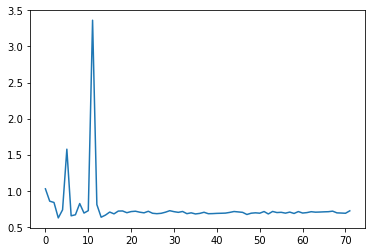

In [12]:
plt.plot(loss_list);

In [ ]:
images, labels = next(iter(train_loader))

print(images.shape, '-', labels.shape)

In [ ]:
images.shape

In [ ]:
images.permute(0, 3, 2, 1).shape

In [ ]:
conv1 = nn.Conv2d(3, 64, kernel_size=5)
x = conv1(images.permute(0, 3, 2, 1).float())
print('c1:', x.shape)# torch.Size([16, 300, 176, 296])

In [ ]:
mp1 = F.max_pool2d(x, 2)
print('mp1:', mp1.shape)

In [ ]:
relu1 = F.relu(mp1)
print('relu:', relu1.shape)

In [ ]:
conv2 = nn.Conv2d(64, 32, kernel_size=5)
c2 = conv2(relu1)
c2.shape

In [ ]:
conv2_drop = nn.Dropout2d()
cd = conv2_drop(c2)
cd.shape

In [ ]:
mp2 = F.max_pool2d(cd, 2)
mp2.shape

In [ ]:
relu2 = F.relu(mp2)
relu2.shape

In [ ]:
conv3 = nn.Conv2d(32, 2, kernel_size=5)
c3 = conv3(relu2)
c3.shape

In [ ]:
mp3 = F.max_pool2d(c3, 2)
mp3.shape

In [ ]:
fc1 = nn.Linear(2*19*34, 1000)
fc2 = nn.Linear(1000, 1)

In [ ]:
x = c3.view(-1, 2*38*68)
x.shape

In [ ]:
x = F.relu(fc1(x))
x.shape

In [ ]:
#x = F.dropout(x, training=self.training)


In [ ]:
x = fc2(x)
print(x.shape)

In [ ]:
out = F.log_softmax(x, dim=1)
print(out.shape)

In [ ]:
2*19*34

In [ ]:
#image.squeeze()

In [ ]:
# Compute accuracy
_, argmax = torch.max(outputs, 1)
correct += (labels == argmax).sum() #.mean()
total += len(labels)

losses.append(loss.item())

In [ ]:
argmax
labels